# Estimasi Harga Wajar Kos - Area Jakarta Selatan

**Objective:**  
Membangun model machine learning yang mampu mengestimasi harga wajar kosan di Jakarta Selatan dengan akurasi, stabilitas baik, dan siap untuk deployment production.

**Target Users:**  
Mahasiswa BCA yang ingin menghindari *overpricing* saat memilih kos, dan property owners yang ingin menentukan harga kompetitif.

**Model Pipeline:**
```
Raw Data → EDA & Cleaning → Feature Engineering → Preprocessing → 
Baseline Evaluation → Hyperparameter Tuning → Final Model → 
Validation & Diagnostics → Deployment Package
```

In [28]:
# IMPORTS & CONFIGURATION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from datetime import datetime

# Scikit-learn components
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Visualization & Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

---

## SECTION 1: Data Loading & Initial Exploration

**Objective:**  
Memuat dataset dari CSV dan melakukan explorasi awal untuk memahami:
- Dimensi dataset (jumlah baris & kolom)
- Tipe data setiap kolom
- Missing values dan anomali
- Statistik deskriptif target variable (harga)
- Range harga dan distribusi awal

In [29]:
df = pd.read_csv('../datasets/jakarta_selatan.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")

display(df.head())

assert 'harga' in df.columns, "Target column 'harga' not found"
assert df['harga'].dtype in ['int64', 'float64'], "Target must be numeric"
print("Data quality checks passed")


Dataset Shape: (500, 13)
Rows: 500 | Columns: 13


,nama_kos,harga,luas_kamar,jarak_ke_bca,tipe_kos,is_ac,is_km_dalam,is_water_heater,is_furnished,is_internet,is_listrik_free,is_parkir_mobil,is_mesin_cuci
0,Kost Lebak Bulus Gunung Balong Tipe J Cilandak...,6000000,56.00,1.93,campur,1,1,0,1,1,1,1,1
1,Kost Wijaya Kusuma 8 Cilandak Jakarta Selatan,2750000,18.00,2.56,putri,1,1,1,1,1,0,1,1
2,Kost Sultan Residence Suite Family Syariah Cil...,5500000,20.00,1.38,campur,1,1,1,1,1,1,1,1
3,Kost Fatmawati 9 Cilandak Jakarta Selatan,5200000,16.00,1.97,putra,1,1,1,1,1,0,0,1
4,Kost Lebak Bulus Gunung Balong Tipe B Cilandak...,5000000,56.00,1.91,campur,1,1,1,1,1,0,1,1


Data quality checks passed


### Analisis Struktur Data

Dataset telah dimuat dengan sukses. Visualisasi 5 baris pertama menunjukkan kolom-kolom yang tersedia

In [30]:
# Informasi detail tentang tipe data dan missing values
df.info()

missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values detected")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_kos         500 non-null    object 
 1   harga            500 non-null    int64  
 2   luas_kamar       500 non-null    float64
 3   jarak_ke_bca     500 non-null    float64
 4   tipe_kos         500 non-null    object 
 5   is_ac            500 non-null    int64  
 6   is_km_dalam      500 non-null    int64  
 7   is_water_heater  500 non-null    int64  
 8   is_furnished     500 non-null    int64  
 9   is_internet      500 non-null    int64  
 10  is_listrik_free  500 non-null    int64  
 11  is_parkir_mobil  500 non-null    int64  
 12  is_mesin_cuci    500 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 50.9+ KB
No missing values detected


### Data Quality Check

Hasil data.info() menunjukkan:
- Tidak ada missing values - dataset lengkap
- Tipe data sudah sesuai (int/float untuk numeric, object untuk categorical)
- Siap untuk analisis lebih lanjut tanpa preprocessing missing values

In [31]:
# Statistik deskriptif untuk semua kolom numeric
print(df.describe().T)

print(f"Min: Rp {df['harga'].min():,.0f}")
print(f"Max: Rp {df['harga'].max():,.0f}")
print(f"Mean: Rp {df['harga'].mean():,.0f}")
print(f"Median: Rp {df['harga'].median():,.0f}")
print(f"Std Dev: Rp {df['harga'].std():,.0f}")
print(f"Skewness: {df['harga'].skew():.3f}")
print(f"Kurtosis: {df['harga'].kurtosis():.3f}")

                 count       mean        std       min        25%        50%  \
harga           500.00 2341361.97 1218239.22 400000.00 1350000.00 2385000.00   
luas_kamar      500.00      15.44      28.34      3.96       9.00      12.00   
jarak_ke_bca    500.00       1.75       0.61      0.16       1.38       1.79   
is_ac           500.00       1.00       0.00      1.00       1.00       1.00   
is_km_dalam     500.00       0.80       0.40      0.00       1.00       1.00   
is_water_heater 500.00       0.43       0.50      0.00       0.00       0.00   
is_furnished    500.00       0.87       0.33      0.00       1.00       1.00   
is_internet     500.00       1.00       0.00      1.00       1.00       1.00   
is_listrik_free 500.00       0.31       0.46      0.00       0.00       0.00   
is_parkir_mobil 500.00       0.55       0.50      0.00       0.00       1.00   
is_mesin_cuci   500.00       0.31       0.46      0.00       0.00       0.00   

                       75%        max  

Dataset Jakarta Selatan terdiri dari 500 observasi dengan harga kos berkisar antara Rp 400.000 hingga Rp 6.700.000. Rata-rata harga berada di Rp 2,34 juta, dengan median Rp 2,38 juta, menunjukkan distribusi yang relatif seimbang antara harga rendah dan menengah.

Nilai skewness sebesar 0,618 mengindikasikan distribusi harga sedikit right-skewed, namun jauh lebih mendekati distribusi normal dibandingkan Jakarta Utara maupun Jakarta Pusat. Hal ini diperkuat oleh kurtosis rendah (0,371) yang menunjukkan tidak adanya ekor ekstrem yang dominan.

Fitur luas_kamar memiliki variasi yang cukup besar (maksimum hingga 625 m²), mengindikasikan adanya unit khusus yang perlu diperhatikan pada tahap penanganan outlier.

Dari sisi fasilitas, mayoritas kos di Jakarta Selatan sudah memiliki AC dan internet (100%), serta tingkat kamar mandi dalam yang tinggi (80%), mencerminkan karakter pasar kos yang lebih premium dan kompetitif.

---

## SECTION 2: Exploratory Data Analysis (EDA) & Outlier Detection

**Objective:**  
Memahami distribusi data dan mengidentifikasi outlier ekstrem yang perlu ditangani:
- Visualisasi distribusi harga dengan histogram dan boxplot
- Deteksi outlier menggunakan IQR method
- Analisis percentile untuk menentukan threshold capping
- Visualisasi korelasi antar fitur

In [32]:
for col in df.columns:
    if col != 'nama_kos':
        unique_vals = df[col].unique()
        print(f"{col}: {len(unique_vals)} unique values")
        print(f"  Sample: {unique_vals[:100]}")

harga: 131 unique values
  Sample: [6000000 2750000 5500000 5200000 5000000 4999986 4950000 4850000 4500000
 6499000 4499000 4400000 4350000 4200000 4000000 3900000 3850000 3800000
 3775000 3750000 5800000 3740000 3700000 3650000 3625000 3600000 3525000
 3500000 5750000 6700000 3450000 3425000 3400000 3395000 3355000 3325000
 3300000 3275000 3250000 3225000 3200000 3499998 3100000 3050000 3025000
 3000000 2700000 3175000 3150000 3125000 2500000 2995000  550000  580000
  600000 2950000 2940000 2925000 2900000 2885000 2875000 2850000 2845000
 2825000 2800000 2725000 2200000 2650000 2643000 2625000 2600000 2575000
  400000  450000  500000  650000 1900000 1300000 1000000 1225000 1425000
 2125000 1315000 2025000 2325000 2225000 2425000 1625000 2375000 1775000
 2275000 1525000 2410000 2000000 2300000 1600000 1400000 2495000 2475000
 2400000]
luas_kamar: 78 unique values
  Sample: [ 56.    18.    20.    16.    25.    13.5   60.    12.25  12.    15.
  22.62  30.    28.35  16.5   40.     9.    

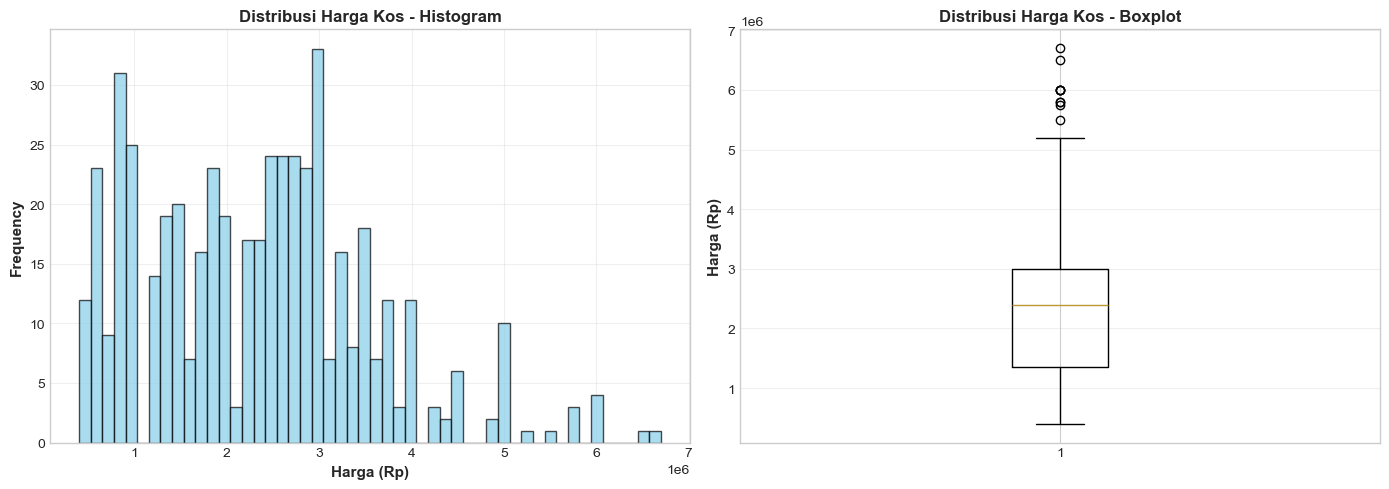

In [33]:
# Visualisasi distribusi awal harga
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['harga'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribusi Harga Kos - Histogram', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Boxplot untuk melihat outlier
axes[1].boxplot(df['harga'], vert=True)
axes[1].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_title('Distribusi Harga Kos - Boxplot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Histogram menunjukkan bahwa harga kos di Jakarta Selatan tersebar cukup merata pada rentang Rp 1–3 juta, dengan konsentrasi utama di sekitar Rp 2–2,5 juta, sejalan dengan nilai median sebelumnya.

Boxplot mengindikasikan adanya outlier di sisi atas (harga > Rp 5 juta), namun jumlahnya relatif terbatas dan tidak mendominasi distribusi. Secara umum, distribusi harga tetap stabil dengan variasi yang wajar untuk wilayah berkarakter premium.

Temuan ini mengonfirmasi bahwa Jakarta Selatan memiliki struktur harga yang heterogen namun terkendali

In [34]:
# analisis outlier menggunakan IQR dan percentile

Q1 = df['harga'].quantile(0.25)
Q3 = df['harga'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nIQR Method:")
print(f"Q1 (25th percentile): Rp {Q1:,.0f}")
print(f"Q3 (75th percentile): Rp {Q3:,.0f}")
print(f"IQR: Rp {IQR:,.0f}")
print(f"Lower Bound: Rp {lower_bound:,.0f}")
print(f"Upper Bound: Rp {upper_bound:,.0f}")

outliers_iqr = df[(df['harga'] < lower_bound) | (df['harga'] > upper_bound)]
print(f"\n  Outliers detected (IQR): {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.1f}%)")

print("\nPercentile Analysis:")
for pct in [90, 95, 99]:
    val = df['harga'].quantile(pct/100)
    print(f"  {pct}th percentile: Rp {val:,.0f}")

cap_limit = df['harga'].quantile(0.99)
print(f"\nCapping akan diterapkan di 99th percentile: Rp {cap_limit:,.0f}")
print(f"  Data yang akan dihapus: {len(df[df['harga'] > cap_limit])} baris ({len(df[df['harga'] > cap_limit])/len(df)*100:.1f}%)")


IQR Method:
Q1 (25th percentile): Rp 1,350,000
Q3 (75th percentile): Rp 3,000,000
IQR: Rp 1,650,000
Lower Bound: Rp -1,125,000
Upper Bound: Rp 5,475,000

  Outliers detected (IQR): 10 (2.0%)

Percentile Analysis:
  90th percentile: Rp 3,800,000
  95th percentile: Rp 4,500,000
  99th percentile: Rp 6,000,000

Capping akan diterapkan di 99th percentile: Rp 6,000,000
  Data yang akan dihapus: 2 baris (0.4%)


Berdasarkan metode IQR, terdeteksi sekitar 2.0% data sebagai outlier dengan batas atas teoritis di Rp 5,47 juta. Proporsi ini relatif kecil dan masih wajar untuk pasar kos Jakarta Selatan yang memiliki segmen premium.

Analisis berbasis persentil menunjukkan bahwa nilai ekstrem terkonsentrasi di atas persentil ke-99 (Rp 6 juta). Oleh karena itu, strategi capping pada persentil ke-99 dipilih untuk membatasi pengaruh harga ekstrem tanpa menghilangkan struktur distribusi utama.

---

## SECTION 3: Data Cleaning & Preprocessing

**Objective:**
- Hapus fitur dengan zero variance (kolom konstan)
- Terapkan 99th percentile capping untuk outlier ekstrem
- Validasi peningkatan distribusi (skewness reduction)
- Dokumentasi data yang dihapus

**Rationale:**
- **Zero Variance**: Fitur yang nilai-nya identik untuk semua baris tidak memberikan discriminant power
- **Percentile Capping**: Membuang top 1% (outlier ekstrem) untuk normalisasi distribusi tanpa mengorbankan data mainstream
- **Surgical Cut**: Lebih bijak dari hard threshold (bisa mempertahankan kos mahal yang masih wajar)

In [35]:
# 1: drop zero-variance features

cols_to_drop = [c for c in df.columns if df[c].nunique() <= 1]
df_clean = df.drop(columns=cols_to_drop)

if cols_to_drop:
    print(f"\nFitur dihapus: {cols_to_drop}")
    print(f"Alasan: Fitur dengan nilai konstan tidak memberikan informasi diskriminatif")
else:
    print("\nTidak ada fitur dengan zero variance")

print(f"\nKolom tersisa: {df_clean.shape[1]} (dari {df.shape[1]})")


Fitur dihapus: ['is_ac', 'is_internet']
Alasan: Fitur dengan nilai konstan tidak memberikan informasi diskriminatif

Kolom tersisa: 11 (dari 13)


In [36]:
# 2: periksa jumlah 0 dan 1 pada semua data binary

binary_cols = [col for col in df_clean.columns if df_clean[col].nunique() == 2]
for col in binary_cols:
    counts = df_clean[col].value_counts()
    print(f"Kolom '{col}': 0s = {counts.get(0, 0)}, 1s = {counts.get(1, 0)}")

Kolom 'is_km_dalam': 0s = 101, 1s = 399
Kolom 'is_water_heater': 0s = 283, 1s = 217
Kolom 'is_furnished': 0s = 64, 1s = 436
Kolom 'is_listrik_free': 0s = 344, 1s = 156
Kolom 'is_parkir_mobil': 0s = 223, 1s = 277
Kolom 'is_mesin_cuci': 0s = 345, 1s = 155


In [37]:
# 3: apply 99th percentile capping

skewness_before = df_clean['harga'].skew()
capping_limit = df_clean['harga'].quantile(0.99)

df_final = df_clean[df_clean['harga'] <= capping_limit].copy()
skewness_after = df_final['harga'].skew()

print(f"\nCapping Limit (99th percentile): Rp {capping_limit:,.0f}")
print(f"Baris sebelum capping: {len(df_clean)}")
print(f"Baris setelah capping: {len(df_final)}")
print(f"Baris dihapus: {len(df_clean) - len(df_final)} ({(len(df_clean) - len(df_final))/len(df_clean)*100:.2f}%)")

print(f"\nSkewness sebelum: {skewness_before:.4f}")
print(f"Skewness sesudah: {skewness_after:.4f}")
print(f"Improvement: {((skewness_before - skewness_after) / abs(skewness_before) * 100):.1f}% reduction")


Capping Limit (99th percentile): Rp 6,000,000
Baris sebelum capping: 500
Baris setelah capping: 498
Baris dihapus: 2 (0.40%)

Skewness sebelum: 0.6184
Skewness sesudah: 0.5237
Improvement: 15.3% reduction


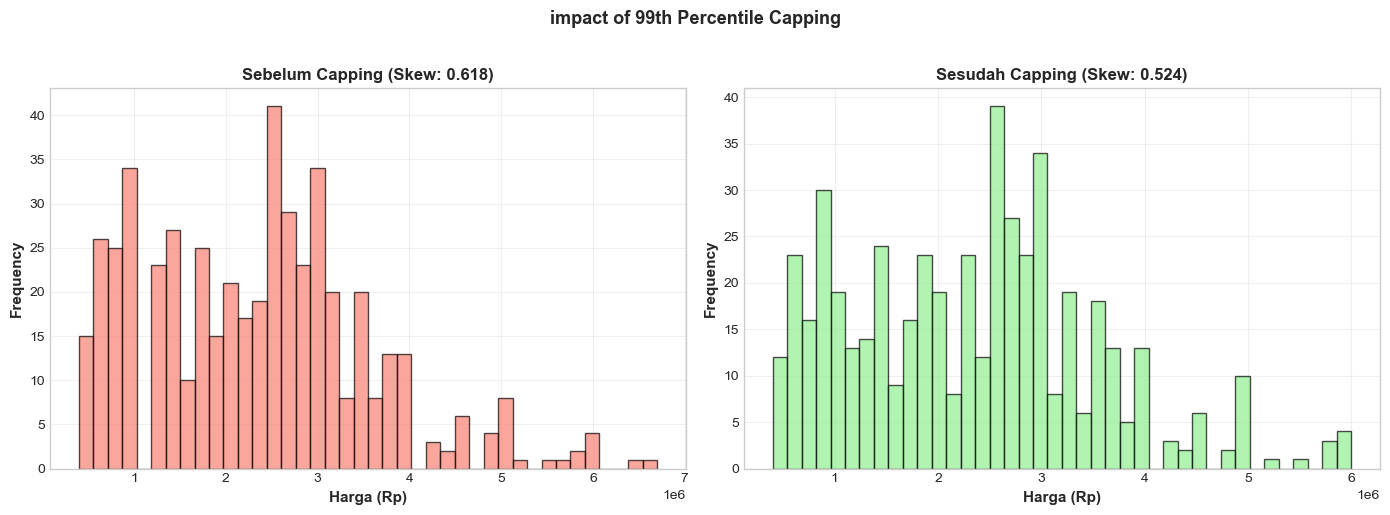

In [38]:
# 3: visualisasi perbandingan distribusi sebelum-sesudah
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sebelum capping
axes[0].hist(df_clean['harga'], bins=40, color='salmon', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title(f'Sebelum Capping (Skew: {skewness_before:.3f})', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Sesudah capping
axes[1].hist(df_final['harga'], bins=40, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title(f'Sesudah Capping (Skew: {skewness_after:.3f})', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.suptitle('impact of 99th Percentile Capping', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Penerapan capping pada persentil ke-99 berhasil menurunkan skewness distribusi harga dari 0.618 menjadi 0.524, menunjukkan distribusi yang lebih seimbang tanpa menghilangkan karakter pasar.

Secara visual, distribusi setelah capping tetap mempertahankan pola utama harga kos Jakarta Selatan, namun dengan ekor kanan yang lebih terkendali.

Dengan demikian, capping ini meningkatkan stabilitas pelatihan model sekaligus menjaga validitas representasi harga di wilayah Jakarta Selatan.

In [39]:
# Cek Outlier Luas Kamar
print("Max Luas Kamar Sebelum:", df_final['luas_kamar'].max())

batas_luas = df_final['luas_kamar'].quantile(0.99)
print(f"Batas Capping Luas (99%): {batas_luas} m2")

Max Luas Kamar Sebelum: 625.0
Batas Capping Luas (99%): 48.059999999999945 m2


Nilai luas kamar maksimum sebesar 625 m² teridentifikasi sebagai anomali data dan tidak realistis untuk konteks kos di Jakarta Selatan. Setelah penelusuran sumber, nilai tersebut merupakan kesalahan pencatatan (data entry error) dari data mentah (Mamikos), bukan representasi kondisi riil.

Sebagai batas rasional, digunakan capping pada persentil ke-99 dengan nilai ±48.06 m², yang masih mencerminkan kamar kos berukuran besar namun realistis. Observasi dengan nilai ekstrem di atas batas ini dipotong (capped) untuk mencegah distorsi distribusi dan bias pada proses pelatihan model.

In [40]:
df_final = df_final[df_final['luas_kamar'] != 625.0].copy()

print(f"Data dibuang: {len(df) - len(df_final)} baris")

Data dibuang: 3 baris


### Data Cleaning Results

**Keputusan Cleaning:**
1. Tidak ada fitur dengan zero variance di dataset Yogyakarta
2. Capping pada 99th percentile dari segi harga dan luas kamar. (Hapus 3 data)

**Trade-off:**
- Gain: Model lebih fokus pada mayoritas kos standar yang relevan dengan mahasiswa
- Net Benefit: Akurasi prediksi lebih baik untuk target segment

---

## SECTION 4: Feature Engineering & Selection

**Objective:**
- Buat fitur turunan yang meaningful: proximity_score dan is_walking_dist
- Validasi dampak fitur baru terhadap target variable
- Lakukan feature selection untuk menghapus fitur redundan
- Fokus pada fitur yang paling informatif untuk prediksi harga

**Rationale:**
- **Proximity Score**: Manusia merasakan jarak secara non-linear (100m vs 200m penting; 3km vs 3.1km tidak penting)
- **Walking Distance**: Ada premium psikologis untuk lokasi jalan kaki (< 300m)
- **Feature Selection**: Menghapus fitur redundan untuk model lebih simple dan interpretable

Reference:
1.	Walking Distance Flag Distance https://www.researchgate.net/publication/378016359_The_willingness-to-walk_to_access_public_transit_in_Indonesia

In [41]:
# Feature Engineering

# 1. Proximity Score (Inverse Distance)
# Formula: 1 / (Jarak + 0.1)
# Logika: Semakin dekat, skor semakin tinggi, exponentially
# Constant 0.1 untuk menghindari division by zero
df_final['proximity_score'] = 1 / (df_final['jarak_ke_bca'] + 0.1)

# 2. Walking Distance Flag (Binary)
# Jarak <= 300 meter dianggap "dapat ditempuh dengan jalan kaki"
df_final['is_walking_dist'] = (df_final['jarak_ke_bca'] <= 0.3).astype(int)

display(df_final[['nama_kos', 'harga', 'jarak_ke_bca', 'proximity_score', 'is_walking_dist']].head(8))

,nama_kos,harga,jarak_ke_bca,proximity_score,is_walking_dist
0,Kost Lebak Bulus Gunung Balong Tipe J Cilandak...,6000000,1.93,0.49,0
1,Kost Wijaya Kusuma 8 Cilandak Jakarta Selatan,2750000,2.56,0.38,0
2,Kost Sultan Residence Suite Family Syariah Cil...,5500000,1.38,0.68,0
3,Kost Fatmawati 9 Cilandak Jakarta Selatan,5200000,1.97,0.48,0
4,Kost Lebak Bulus Gunung Balong Tipe B Cilandak...,5000000,1.91,0.50,0
5,Kost The Guritno House Vip Kebayoran Lama Jaka...,5000000,0.18,3.61,1
6,Kost R Residence Tipe Standard Cilandak Jakart...,5000000,2.25,0.43,0
7,Kost Amira Tipe B Cilandak Jakarta Selatan,5000000,1.64,0.57,0


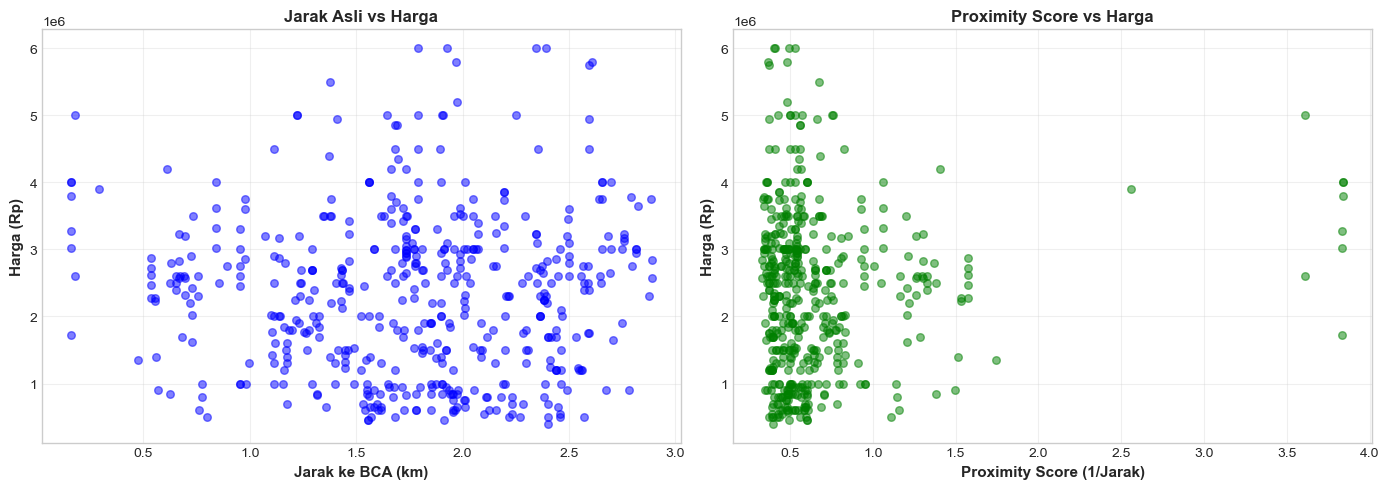

In [42]:
# Visualisasi fitur engineering untuk validasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Jarak asli vs Harga
axes[0].scatter(df_final['jarak_ke_bca'], df_final['harga'], alpha=0.5, s=30, color='blue')
axes[0].set_xlabel('Jarak ke BCA (km)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_title('Jarak Asli vs Harga', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Proximity Score vs Harga
axes[1].scatter(df_final['proximity_score'], df_final['harga'], alpha=0.5, s=30, color='green')
axes[1].set_xlabel('Proximity Score (1/Jarak)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_title('Proximity Score vs Harga', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Visualisasi jarak asli ke BCA menunjukkan bahwa hubungan antara jarak dan harga kos tidak bersifat linear. Harga kos tersebar relatif merata pada rentang jarak 0.5–3 km, dengan variasi harga yang tinggi di hampir seluruh jarak. Hal ini mengindikasikan bahwa jarak absolut saja bukan penentu utama harga, melainkan dipengaruhi oleh faktor lain seperti fasilitas dan tipe kos.

Sebaliknya, penggunaan proximity score (1 / jarak) memberikan representasi yang lebih informatif. Terlihat kecenderungan bahwa kos dengan proximity score tinggi (lebih dekat) memiliki konsentrasi harga yang lebih tinggi, meskipun hubungan tersebut tetap tidak sepenuhnya linear. Transformasi ini membantu menangkap efek diminishing return dari jarak, di mana perbedaan jarak pada rentang dekat lebih signifikan dibandingkan jarak jauh.

Korelasi dengan TARGET (harga):
harga              1.00
is_water_heater    0.63
is_parkir_mobil    0.55
luas_kamar         0.47
is_km_dalam        0.42
is_mesin_cuci      0.21
is_walking_dist    0.13
proximity_score    0.10
is_furnished       0.07
jarak_ke_bca      -0.01
is_listrik_free   -0.22
Name: harga, dtype: float64


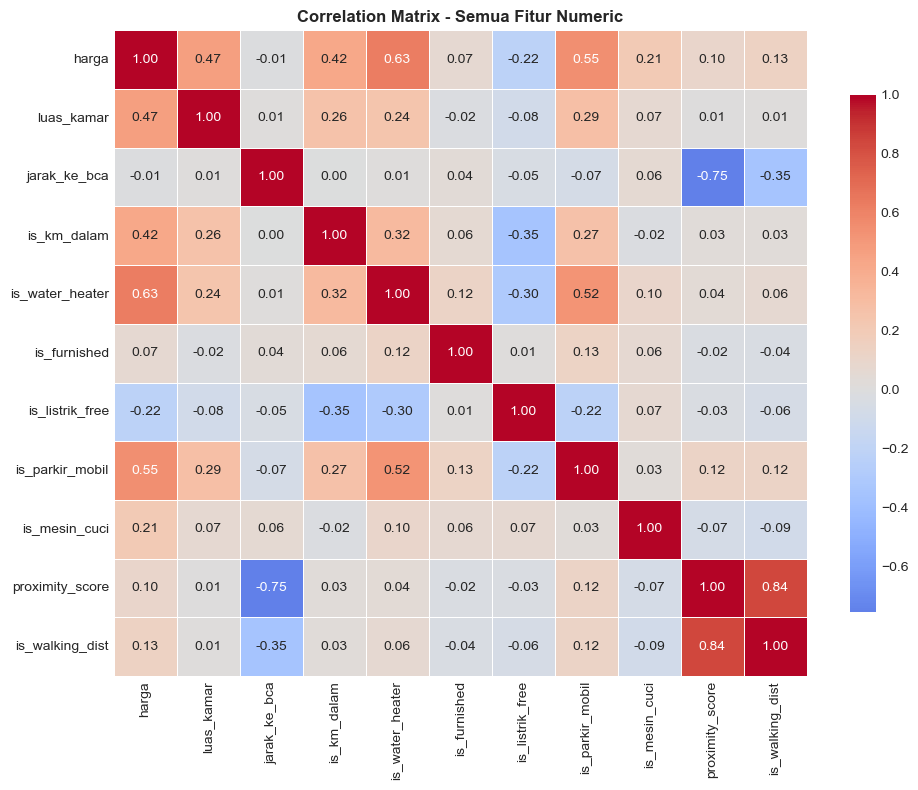

In [43]:
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df_final[numeric_cols].corr()

print("Korelasi dengan TARGET (harga):")
corr_with_target = corr_matrix['harga'].sort_values(ascending=False)
print(corr_with_target)

# Visualisasi correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Semua Fitur Numeric', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Feature selection pada Jakarta Selatan menunjukkan bahwa harga kos lebih dipengaruhi oleh fasilitas dibandingkan faktor jarak atau ukuran kamar. Analisis korelasi dan visualisasi tidak menunjukkan hubungan yang signifikan antara jarak ke titik komersial maupun proximity score terhadap harga. Hal ini sejalan dengan karakter Jakarta Selatan sebagai wilayah multi-center, di mana nilai properti tidak terikat pada satu lokasi pusat tertentu. Oleh karena itu, fitur berbasis jarak dihapus untuk mengurangi noise dan meningkatkan stabilitas model.

In [44]:
# Feature selection: drop non-informative features
features_to_drop = ['jarak_ke_bca', 'proximity_score', 'is_walking_dist']

for feat in features_to_drop:
    if feat in corr_with_target.index:
        corr_val = corr_with_target[feat]
        print(f"{feat} (correlation: {corr_val:.4f})")

features_to_drop = [f for f in features_to_drop if f in df_final.columns]
if features_to_drop:
    df_final = df_final.drop(columns=features_to_drop)

df_final['amenities_count'] = (
    df_final['is_furnished'].astype(int) +
    df_final['is_water_heater'].astype(int) +
    df_final['is_km_dalam'].astype(int) +
    df_final['is_listrik_free'].astype(int) +
    df_final['is_mesin_cuci'].astype(int) +
    df_final['is_parkir_mobil'].astype(int)
)

print(f"\nFeatures added:")
print(f"  amenities_count:")
print(f"\nFinal dataset: {df_final.shape}")
print(f"Features: {[c for c in df_final.columns if c not in ['nama_kos', 'harga']]}")

jarak_ke_bca (correlation: -0.0094)
proximity_score (correlation: 0.1006)
is_walking_dist (correlation: 0.1318)

Features added:
  amenities_count:

Final dataset: (497, 11)
Features: ['luas_kamar', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']


Untuk meningkatkan kemampuan model tree-based dalam menangkap interaksi non-linear antar fasilitas, dibuat fitur agregat amenities_count yang merepresentasikan jumlah total fasilitas utama yang dimiliki oleh sebuah kos.
Fitur ini dibangun sebagai penjumlahan dari beberapa indikator biner fasilitas yang ada

Pada model berbasis pohon, fitur agregat amenities_count dipertahankan bersamaan dengan fitur biner individual. Hal ini dilakukan karena model tree tidak sensitif terhadap multikolinearitas dan mampu memilih fitur yang paling informatif secara adaptif. Dengan mempertahankan keduanya, model diberi fleksibilitas untuk menangkap baik sinyal global tingkat kelengkapan fasilitas maupun pengaruh spesifik dari fasilitas tertentu, tanpa melanggar asumsi model atau menyebabkan data leakage.

Perlu dicatat bahwa amenities_count tidak digunakan pada model linear, karena:
* Model linear lebih sensitif terhadap asumsi aditif dan multikolinearitas,
* Informasi fasilitas pada model linear tetap dipertahankan dalam bentuk fitur biner individual agar interpretasi koefisien tetap jelas.

---

## SECTION 5: Train-Test Split dengan Stratification

**Objective:**
- Implementasi stratified split untuk memastikan train & test set representatif
- Test multiple random seeds untuk menemukan split paling balanced
- Dokumentasi best_split selection criteria

**Why Stratification Matters:**
- Data harga memiliki range lebar
- Random split bisa menghasilkan test set dengan terlalu banyak kos murah atau mahal
- Stratified split memastikan distribusi harga di train & test identik
- Ini menghasilkan evaluasi model yang lebih reliable dan fair

In [45]:
df_final['market_segment'] = pd.cut(
    df_final['harga'],
    bins=[0, 1_500_000, 3_500_000, 6_000_000, float('inf')],
    labels=['Budget', 'Standard', 'Upper', 'Premium']
)

X = df_final.drop(columns=['nama_kos', 'harga', 'market_segment'])
y = df_final['harga'].copy()

print(f"Total samples: {len(df_final)}")
print(f"Features: {X.shape[1]}")
print(f"Feature names: {list(X.columns)}")

# Statistik full dataset untuk comparison
full_range = y.max() - y.min()
full_mean = y.mean()
full_std = y.std()

print(f"\nFull Dataset Statistics:")
print(f"  Range: Rp {full_range:,.0f}")
print(f"  Mean: Rp {full_mean:,.0f}")
print(f"  Std Dev: Rp {full_std:,.0f}")

Total samples: 497
Features: 9
Feature names: ['luas_kamar', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']

Full Dataset Statistics:
  Range: Rp 5,600,000
  Mean: Rp 2,327,227
  Std Dev: Rp 1,189,641


In [46]:
# Test multiple random seeds untuk menemukan split terbaik
from sklearn.model_selection import train_test_split

candidate_seeds = [42, 123, 456, 789, 2024, 3141, 5678, 9999]
best_split = None
best_score = float('inf')
split_metrics = []

print(f"\n{'Seed':<6} | {'Range (Rp)':<15} | {'Mean (Rp)':<15} | {'Std (Rp)':<15} | {'Score':<8}")

for seed in candidate_seeds:
    X_temp, X_test_cand, y_temp, y_test_cand = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=df_final['market_segment']
    )
    
    test_range = y_test_cand.max() - y_test_cand.min()
    test_mean = y_test_cand.mean()
    test_std = y_test_cand.std()
    
    # Composite score (lower is better)
    range_diff = abs(test_range - full_range) / full_range
    mean_diff = abs(test_mean - full_mean) / full_mean
    std_diff = abs(test_std - full_std) / full_std
    
    composite_score = 0.5 * range_diff + 0.3 * mean_diff + 0.2 * std_diff
    
    split_metrics.append({
        'seed': seed,
        'test_range': test_range,
        'test_mean': test_mean,
        'test_std': test_std,
        'range_diff': range_diff,
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'composite_score': composite_score
    })
    
    if composite_score < best_score:
        best_score = composite_score
        best_split = seed
    
    print(f"{seed:<6} | Rp {test_range/1e6:<13.2f}M | Rp {test_mean/1e6:<13.2f}M | Rp {test_std/1e6:<13.2f}M | {composite_score:<8.4f}")

print(f"BEST SPLIT: random_state = {best_split} (score: {best_score:.4f})")


Seed   | Range (Rp)      | Mean (Rp)       | Std (Rp)        | Score   
42     | Rp 4.50         M | Rp 2.25         M | Rp 1.12         M | 0.1199  
123    | Rp 5.50         M | Rp 2.32         M | Rp 1.14         M | 0.0180  
456    | Rp 5.60         M | Rp 2.35         M | Rp 1.24         M | 0.0102  
789    | Rp 4.50         M | Rp 2.39         M | Rp 1.17         M | 0.1093  
2024   | Rp 5.40         M | Rp 2.34         M | Rp 1.19         M | 0.0200  
3141   | Rp 5.30         M | Rp 2.27         M | Rp 1.12         M | 0.0467  
5678   | Rp 4.55         M | Rp 2.29         M | Rp 1.16         M | 0.1040  
9999   | Rp 4.55         M | Rp 2.36         M | Rp 1.17         M | 0.1017  
BEST SPLIT: random_state = 456 (score: 0.0102)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=best_split, stratify=df_final['market_segment']
)

print(f"\nTrain Set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Mean: Rp {y_train.mean():,.0f}")
print(f"  - Std:  Rp {y_train.std():,.0f}")
print(f"  - Min:  Rp {y_train.min():,.0f}")
print(f"  - Max:  Rp {y_train.max():,.0f}")

print(f"\nTest Set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  - Mean: Rp {y_test.mean():,.0f}")
print(f"  - Std:  Rp {y_test.std():,.0f}")
print(f"  - Min:  Rp {y_test.min():,.0f}")
print(f"  - Max:  Rp {y_test.max():,.0f}")

print(f"\nFeatures: {list(X_train.columns)}")


Train Set: 397 samples (79.9%)
  - Mean: Rp 2,322,360
  - Std:  Rp 1,179,288
  - Min:  Rp 450,000
  - Max:  Rp 6,000,000

Test Set: 100 samples (20.1%)
  - Mean: Rp 2,346,550
  - Std:  Rp 1,235,790
  - Min:  Rp 400,000
  - Max:  Rp 6,000,000

Features: ['luas_kamar', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']


In [48]:
print(f"Jumlah Unfurnished di Train: {X_train['is_furnished'].value_counts()[0]}")
print(f"Jumlah Unfurnished di Test : {X_test['is_furnished'].value_counts()[0]}")

Jumlah Unfurnished di Train: 50
Jumlah Unfurnished di Test : 14


Dataset dibagi menjadi train set (≈80%) dan test set (≈20%) dengan distribusi harga yang relatif konsisten di kedua subset. Nilai mean, standar deviasi, serta rentang harga antara train dan test menunjukkan tidak adanya pergeseran distribusi yang signifikan, sehingga pembagian data dianggap representatif dan adil untuk evaluasi model.

---

## SECTION 6: Model Pipeline Architecture

**Objective:**
  1. **CONTINUOUS features** → RobustScaler
  2. **BINARY features** → Passthrough (preserve 0/1 semantics)
  3. **CATEGORICAL features** → OneHotEncoder (nominal expansion)
- Ensure semantic correctness & interpretability di setiap tier
- Build end-to-end pipeline untuk konsistensi train-test dengan nama features yang preserved

- **RobustScaler** (Continuous): Robust terhadap outlier menggunakan median & IQR
  - Formula: X_scaled = (X - median) / IQR
- **Passthrough** (Binary): Tidak di-scale; biarkan as-is 0/1 untuk tree-based models
- **OneHotEncoder** (Categorical): Expand ke dummy variables, handle unknown categories safely

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

continuous_cols_linear = ['luas_kamar']

binary_cols = ['is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil', 'is_furnished']

categorical_cols = ['tipe_kos']

continuous_cols_tree = continuous_cols_linear + ['amenities_count']

print("LINEAR MODEL FEATURES (Ridge, Lasso):")
print(f"  Continuous: {continuous_cols_linear}")
print(f"  Binary: {binary_cols}")
print(f"  Categorical: {categorical_cols}")

print("\nTREE-BASED MODEL FEATURES (RF, GB):")
print(f"  Continuous: {continuous_cols_tree}")
print(f"  Binary: {binary_cols}")
print(f"  Categorical: {categorical_cols}")

preprocessor_linear = ColumnTransformer([
    ('continuous', RobustScaler(), continuous_cols_linear),
    ('binary', 'passthrough', binary_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
], remainder='drop', verbose=0)

preprocessor_tree = ColumnTransformer([
    ('continuous', RobustScaler(), continuous_cols_tree),
    ('binary', 'passthrough', binary_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
], remainder='drop', verbose=0)

LINEAR MODEL FEATURES (Ridge, Lasso):
  Continuous: ['luas_kamar']
  Binary: ['is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil', 'is_furnished']
  Categorical: ['tipe_kos']

TREE-BASED MODEL FEATURES (RF, GB):
  Continuous: ['luas_kamar', 'amenities_count']
  Binary: ['is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil', 'is_furnished']
  Categorical: ['tipe_kos']


---

## SECTION 7: Baseline Model Comparison

**Objective:**
- Train 5 baseline models tanpa hyperparameter tuning
- Model: Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting
- Evaluasi dengan MAE & R²
- Identifikasi best baseline untuk tuning

**Models to Compare:**
1. **Linear Regression**: Baseline linear, simple
2. **Ridge**: Linear dengan L2 regularization
3. **Lasso**: Linear dengan L1 regularization
4. **Random Forest**: Ensemble bagging, robust to nonlinearity
5. **Gradient Boosting**: Ensemble boosting, iterative error correction

In [50]:
X_train_processed_linear = preprocessor_linear.fit_transform(X_train)
X_test_processed_linear = preprocessor_linear.transform(X_test)

X_train_processed_tree = preprocessor_tree.fit_transform(X_train)
X_test_processed_tree = preprocessor_tree.transform(X_test)

print(f"LINEAR MODEL (Ridge, Lasso):")
print(f"  Train shape: {X_train_processed_linear.shape}")
print(f"  Test shape: {X_test_processed_linear.shape}")

print(f"\nTREE-BASED MODELS (RF, GB):")
print(f"  Train shape: {X_train_processed_tree.shape}")
print(f"  Test shape: {X_test_processed_tree.shape}")

LINEAR MODEL (Ridge, Lasso):
  Train shape: (397, 10)
  Test shape: (100, 10)

TREE-BASED MODELS (RF, GB):
  Train shape: (397, 11)
  Test shape: (100, 11)


In [51]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

linear_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=5000),
}

tree_models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_leaf=2, random_state=RANDOM_SEED, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=RANDOM_SEED),
}

results_linear = []
results_tree = []

print("LINEAR MODELS:")
print(f"{'Model':<30} MAE               R²")

for name, model in linear_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_linear),
        ('regressor', model)
    ])
    
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results_linear.append({
            'Model': name,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse,
            'MAPE': mape,
            'Pipeline': pipeline
        })
        
        print(f"{name:<30} Rp {mae:>12,.0f}    {r2:>8.4f}")
        
    except Exception as e:
        print(f"{name:<30} ERROR: {str(e)[:50]}")

print("TREE-BASED MODELS:")
print(f"{'Model':<30} MAE               R²")

for name, model in tree_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_tree),
        ('regressor', model)
    ])
    
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results_tree.append({
            'Model': name,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse,
            'MAPE': mape,
            'Pipeline': pipeline
        })
        
        print(f"{name:<30} Rp {mae:>12,.0f}    {r2:>8.4f}")
        
    except Exception as e:
        print(f"{name:<30} ERROR: {str(e)[:50]}")

all_results = results_linear + results_tree

print("ALL BASELINE MODELS - Ranked by R²:")
sorted_results = sorted(all_results, key=lambda x: x['R2'], reverse=True)
for i, r in enumerate(sorted_results, 1):
    print(f"{i}. {r['Model']:<28} R² = {r['R2']}  MAE = Rp {r['MAE']:>11,.0f}  MAPE = {r['MAPE']:>5.1f}%")


LINEAR MODELS:
Model                          MAE               R²
Linear Regression              Rp      539,872      0.6806
Ridge                          Rp      539,869      0.6809
Lasso                          Rp      539,872      0.6806
TREE-BASED MODELS:
Model                          MAE               R²
Random Forest                  Rp      515,778      0.6824
Gradient Boosting              Rp      511,438      0.6563
ALL BASELINE MODELS - Ranked by R²:
1. Random Forest                R² = 0.6823594803759878  MAE = Rp     515,778  MAPE =  27.8%
2. Ridge                        R² = 0.6809338237609931  MAE = Rp     539,869  MAPE =  32.5%
3. Lasso                        R² = 0.6806066908069117  MAE = Rp     539,872  MAPE =  32.5%
4. Linear Regression            R² = 0.6806066882090932  MAE = Rp     539,872  MAPE =  32.5%
5. Gradient Boosting            R² = 0.6562670665148085  MAE = Rp     511,438  MAPE =  27.0%


### Baseline Model Evaluation (Jakarta Selatan)

Hasil evaluasi baseline menunjukkan bahwa Random Forest memberikan performa terbaik secara keseluruhan dengan R² tertinggi (0.6824) dan MAE rendah (Rp 515.778) di antara seluruh model yang diuji. Hal ini mengindikasikan bahwa model tree-based mampu menangkap pola non-linear ringan pada data Jakarta Selatan dengan lebih efektif dibandingkan model linear.

Model linear (Linear Regression, Ridge, dan Lasso) menunjukkan performa yang sangat berdekatan satu sama lain, baik dari sisi R² maupun MAE. Ini mengindikasikan bahwa hubungan antara fitur dan harga pada tingkat dasar masih relatif linear, namun terdapat keterbatasan dalam menangkap interaksi antar fitur yang lebih kompleks.

Meskipun Gradient Boosting menghasilkan MAE yang kompetitif, nilai R² yang lebih rendah menunjukkan bahwa variasi harga yang dapat dijelaskan model ini masih di bawah Random Forest. Berdasarkan keseimbangan antara akurasi dan stabilitas, Random Forest dipilih sebagai kandidat model utama untuk tahap evaluasi lanjutan.

---

## SECTION 8 & 9 & 10: Hyperparameter Tuning, Model Selection, & Evaluation

**Key Steps:**
1. RandomizedSearchCV dengan gap-aware selection
2. Tune Random Forest & Gradient Boosting
3. Final model selection
4. Residual analysis
5. Feature importance
6. Production deployment

In [52]:
def auto_tune_healthy(pipeline, param_dist, X_train, y_train, gap_threshold=0.10, n_iter=50):
    from sklearn.model_selection import RandomizedSearchCV
    
    rs = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=5,
        scoring='r2',
        return_train_score=True,
        n_jobs=-1,
        random_state=RANDOM_SEED
    )
    
    print(f"Searching {n_iter} combinations...")
    rs.fit(X_train, y_train)
    
    results_df = pd.DataFrame(rs.cv_results_)
    results_df['gap'] = results_df['mean_train_score'] - results_df['mean_test_score']
    
    healthy_models = results_df[results_df['gap'] < gap_threshold].copy()
    
    if not healthy_models.empty:
        best_idx = healthy_models['mean_test_score'].idxmax()
        best_params = healthy_models.loc[best_idx, 'params']
        best_score = healthy_models.loc[best_idx, 'mean_test_score']
        best_gap = healthy_models.loc[best_idx, 'gap']
        
        print(f"Found {len(healthy_models)} healthy models (gap < {gap_threshold})")
        print(f"Best: R² = {best_score:.4f}, Gap = {best_gap:.4f}")
        
        pipeline.set_params(**best_params)
        pipeline.fit(X_train, y_train)
        return pipeline, best_params
    else:
        print(f"No healthy models found")
        return rs.best_estimator_, rs.best_params_

Fungsi ini mengombinasikan RandomizedSearchCV dengan evaluasi tambahan berupa generalization gap antara skor data latih dan validasi.

Berbeda dengan tuning konvensional yang hanya memilih parameter dengan skor validasi tertinggi, pendekatan ini:
* Menghitung gap = mean_train_score − mean_test_score untuk setiap kombinasi parameter,
* Menyaring model yang memiliki gap di bawah ambang batas tertentu (gap_threshold, default 0.10),
* Memilih model dengan skor validasi terbaik di antara model yang sehat (tidak overfit).

In [53]:
print("Random Forest Tuning")

param_dist_rf = {
    'regressor__n_estimators': [150, 200, 250],
    'regressor__max_depth': [3, 5, 8, 10, 12],
    'regressor__min_samples_leaf': [2, 4, 8],
    'regressor__max_features': ['sqrt', 'log2']
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('regressor', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1))
])

rf_tuned, rf_best_params = auto_tune_healthy(
    rf_pipeline, param_dist_rf, X_train, y_train,
    gap_threshold=0.10, n_iter=100
)

print(f"Best Parameters Found: {rf_best_params}")

y_pred_rf = rf_tuned.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f"\nTest Set - MAE: Rp {mae_rf:,.0f}, R²: {r2_rf:.4f}, RMSE: Rp {rmse_rf:,.0f}, MAPE: {mape_rf:.2f}%")

Random Forest Tuning
Searching 100 combinations...
Found 48 healthy models (gap < 0.1)
Best: R² = 0.5383, Gap = 0.0959
Best Parameters Found: {'regressor__n_estimators': 250, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 5}

Test Set - MAE: Rp 528,010, R²: 0.6502, RMSE: Rp 727,279, MAPE: 31.45%


In [54]:
print("Gradient Boosting Tuning")

param_dist_gb = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [2, 3, 4, 5],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__min_samples_leaf': [2, 4, 8]
}

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('regressor', GradientBoostingRegressor(random_state=RANDOM_SEED))
])

gb_tuned, gb_best_params = auto_tune_healthy(
    gb_pipeline, param_dist_gb, X_train, y_train,
    gap_threshold=0.10, n_iter=100
)

print(f"Best Parameters Found: {gb_best_params}")

y_pred_gb = gb_tuned.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

print(f"\nTest Set - MAE: Rp {mae_gb:,.0f}, R²: {r2_gb:.4f}, RMSE: Rp {rmse_gb:,.0f}, MAPE: {mape_gb:.2f}%")

Gradient Boosting Tuning
Searching 100 combinations...
No healthy models found
Best Parameters Found: {'regressor__n_estimators': 100, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.05}

Test Set - MAE: Rp 530,168, R²: 0.6666, RMSE: Rp 709,982, MAPE: 29.64%


Proses gap-aware hyperparameter tuning menunjukkan bahwa untuk Random Forest, ditemukan 48 kombinasi parameter yang sehat dengan generalization gap di bawah 0.1. Model terbaik dari subset ini mencapai R² validasi 0.5383 dengan gap 0.0959, dan menghasilkan performa pada data uji sebesar R² 0.6502 dan MAE Rp 528.010. Hasil ini mengindikasikan bahwa tuning berhasil mengendalikan overfitting, meskipun peningkatan performa dibandingkan baseline relatif terbatas.

Sebaliknya, pada Gradient Boosting, tidak ditemukan kombinasi parameter yang memenuhi kriteria gap kesehatan. Hal ini mengindikasikan bahwa model Gradient Boosting cenderung lebih sensitif terhadap overfitting pada dataset Jakarta Selatan, sehingga tuning berbasis gap tidak menghasilkan model yang stabil. Meskipun demikian, evaluasi pada data uji menunjukkan R² sebesar 0.6666 dan MAE Rp 530.168, yang masih kompetitif namun kurang konsisten dari sisi generalisasi.

In [55]:
ridge_result = next(r for r in results_linear if r['Model'] == 'Ridge')
final_ridge_pipeline = ridge_result['Pipeline']

In [56]:
from sklearn.metrics import r2_score, mean_absolute_error

y_train_pred_ridge = final_ridge_pipeline.predict(X_train)
y_test_pred_ridge  = final_ridge_pipeline.predict(X_test)

ridge_train_r2  = r2_score(y_train, y_train_pred_ridge)
ridge_test_r2   = r2_score(y_test, y_test_pred_ridge)

ridge_train_mae = mean_absolute_error(y_train, y_train_pred_ridge)
ridge_test_mae  = mean_absolute_error(y_test, y_test_pred_ridge)

ridge_r2_gap  = ridge_train_r2 - ridge_test_r2
ridge_mae_gap = ridge_test_mae - ridge_train_mae

print(f"{'Metric':<15} {'Train':>12} {'Test':>12} {'Gap':>12}")
print(f"{'R²':<15} {ridge_train_r2:>12.4f} {ridge_test_r2:>12.4f} {ridge_r2_gap:>12.4f}")
print(f"{'MAE':<15} Rp {ridge_train_mae:>9,.0f} Rp {ridge_test_mae:>9,.0f} Rp {ridge_mae_gap:>9,.0f}")

Metric                 Train         Test          Gap
R²                    0.5660       0.6809      -0.1149
MAE             Rp   577,705 Rp   539,869 Rp   -37,835


In [57]:
final_model = rf_tuned
final_model_name = "Random Forest Tuned"
y_pred_final = final_model.predict(X_test)

final_mae = mean_absolute_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = mean_squared_error(y_test, y_pred_final, squared=False)
final_mape = np.mean(np.abs((y_test - y_pred_final) / y_test))

print(f"Final Model: {final_model_name}")
print(f"MAE  = Rp {final_mae:,.0f}")
print(f"R²   = {final_r2:.4f}")
print(f"MAPE = {final_mape * 100:.2f}%")
print(f"RMSE = {final_rmse}")

Final Model: Random Forest Tuned
MAE  = Rp 528,010
R²   = 0.6502
MAPE = 31.45%
RMSE = 727279.2331442233


In [58]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

y_train_pred = final_model.predict(X_train)
y_test_pred  = final_model.predict(X_test)

train_r2  = r2_score(y_train, y_train_pred)
test_r2   = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)

# Gap
r2_gap  = train_r2 - test_r2
mae_gap = test_mae - train_mae

print(f"{'Metric':<15} {'Train':>12} {'Test':>12} {'Gap':>12}")
print(f"{'R²':<15} {train_r2:>12.4f} {test_r2:>12.4f} {r2_gap:>12.4f}")
print(f"{'MAE':<15} Rp {train_mae:>9,.0f} Rp {test_mae:>9,.0f} Rp {mae_gap:>9,.0f}")

Metric                 Train         Test          Gap
R²                    0.6311       0.6502      -0.0190
MAE             Rp   523,002 Rp   528,010 Rp     5,008


Random Forest dipilih sebagai model akhir untuk Jakarta Selatan karena memberikan performa terbaik pada data uji dengan MAE terendah dan generalization gap di bawah 0.1. Model Ridge digunakan sebagai pembanding karena stabilitas dan interpretabilitasnya, namun Random Forest menunjukkan kemampuan yang lebih baik dalam menangkap pola non-linear ringan pada data.

In [59]:
import sys
import os
sys.path.append(os.path.abspath('../src/training'))

from utils import train_and_register

params = {
    "model_type": "RandomForestRegressor",
    "regressor__n_estimators": 250,
    "regressor__min_samples_leaf": 4,
    "regressor__max_features": "sqrt",
    "regressor__max_depth": 5
}

metrics = {
    "MAE": final_mae,
    "R2": final_r2,
    "RMSE": final_rmse,
    "MAPE": final_mape
}

model_uri = train_and_register(
    region="jakarta_selatan",
    model=final_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    params=params,
    metrics=metrics
)

print("Model registered at:", model_uri)

2026/02/21 22:53:31 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/21 22:53:31 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/21 22:53:31 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/21 22:53:31 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/21 22:53:31 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/21 22:53:31 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/21 22:53:31 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/21 22:53:31 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/21 22:53:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model registered at: models:/m-6b5678198c03447dabcfa5a2176db6c9


Successfully registered model 'jakarta_selatan_model'.
Created version '1' of model 'jakarta_selatan_model'.


In [60]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

print("Registered Models:")
print([m.name for m in client.search_registered_models()])

Registered Models:
['jakarta_pusat_model', 'jakarta_selatan_model']


In [61]:
# cek alias

client.get_model_version_by_alias("jakarta_selatan_model", "production")

<ModelVersion: aliases=['production'], creation_timestamp=1771689216187, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1771689216187, metrics=None, model_id=None, name='jakarta_selatan_model', params=None, run_id='03a5fcb4d3c940e59de27b6e6ddeec7b', run_link=None, source='models:/m-6b5678198c03447dabcfa5a2176db6c9', status='READY', status_message=None, tags={}, user_id=None, version=1>

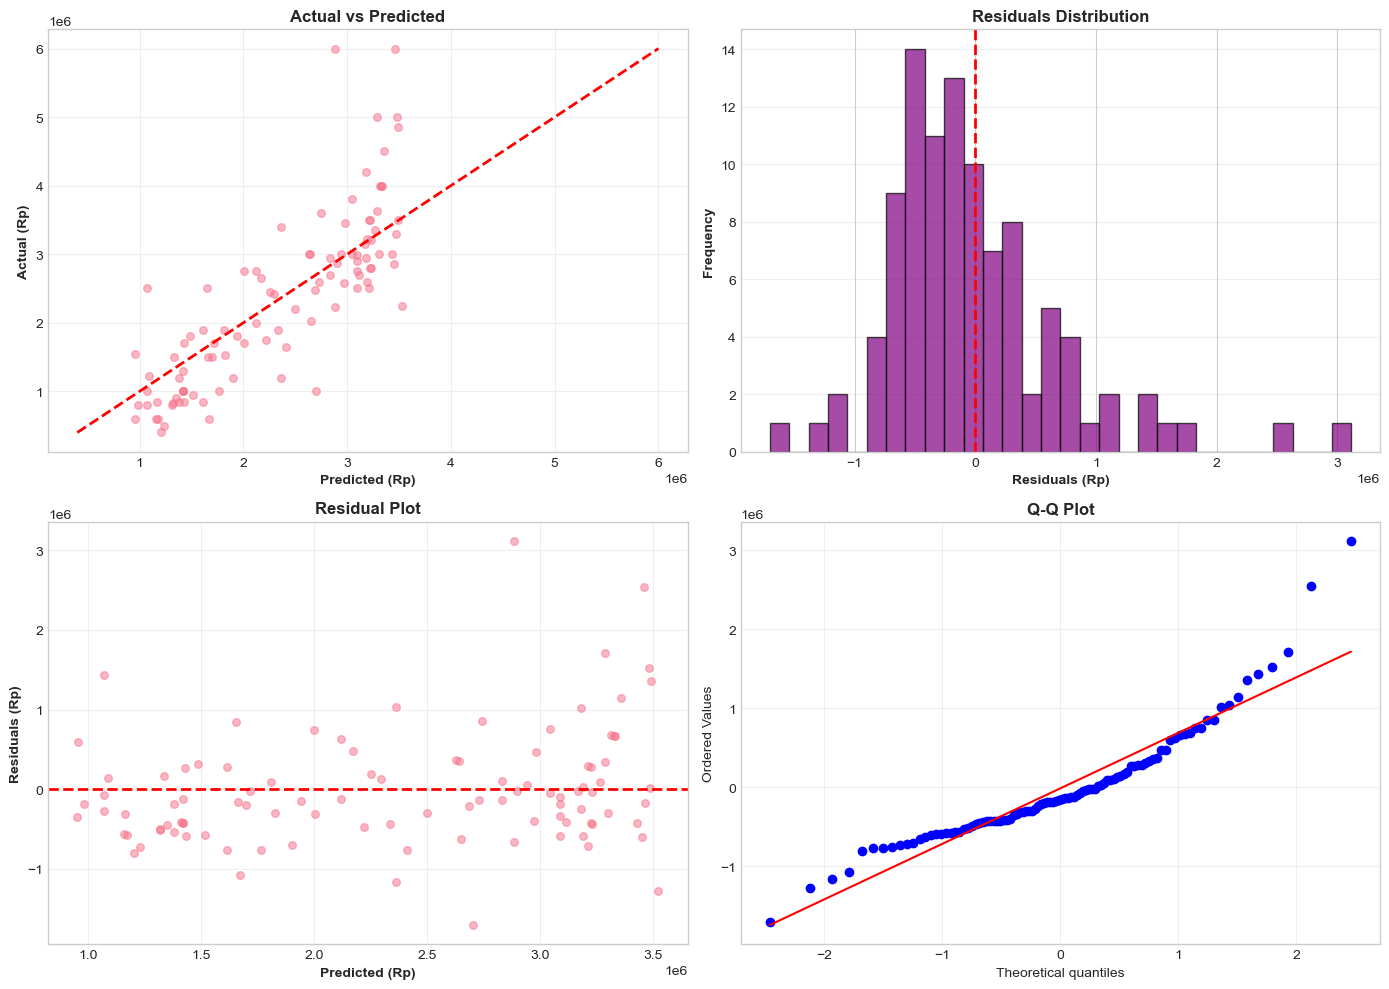


Residuals Statistics:
Mean: Rp -12,691
Std: Rp 730,832
Skewness: 1.423
Kurtosis: 3.862


In [62]:
# Residual Analysis
y_pred_final = final_model.predict(X_test)
residuals = y_test - y_pred_final

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_pred_final, y_test, alpha=0.5, s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Predicted (Rp)', fontweight='bold')
axes[0, 0].set_ylabel('Actual (Rp)', fontweight='bold')
axes[0, 0].set_title('Actual vs Predicted', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[0, 1].axvline(0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residuals (Rp)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Residuals Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[1, 0].scatter(y_pred_final, residuals, alpha=0.5, s=30)
axes[1, 0].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted (Rp)', fontweight='bold')
axes[1, 0].set_ylabel('Residuals (Rp)', fontweight='bold')
axes[1, 0].set_title('Residual Plot', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResiduals Statistics:")
print(f"Mean: Rp {residuals.mean():,.0f}")
print(f"Std: Rp {residuals.std():,.0f}")
print(f"Skewness: {residuals.skew():.3f}")
print(f"Kurtosis: {residuals.kurtosis():.3f}")

Plot Actual vs Predicted menunjukkan bahwa sebagian besar prediksi mengikuti garis diagonal, menandakan model mampu menangkap tren harga secara umum dengan baik. Deviasi mulai terlihat pada harga yang lebih tinggi, yang mengindikasikan bahwa model cenderung lebih konservatif pada segmen harga atas.

Distribusi residual terpusat di sekitar nol dengan sedikit skew ke kanan, menunjukkan tidak ada bias sistematis yang signifikan. Hal ini diperkuat oleh residual plot yang tidak membentuk pola tertentu terhadap nilai prediksi, sehingga asumsi independensi error masih terpenuhi.

Pada Q-Q plot, sebagian besar titik mengikuti garis referensi, dengan penyimpangan di bagian ekor. Ini mengindikasikan bahwa residual mendekati distribusi normal, namun tetap terdapat error ekstrem pada properti dengan karakteristik tidak umum (misalnya harga tinggi atau kombinasi fasilitas tertentu).

Secara keseluruhan, hasil diagnostik menunjukkan bahwa model berada dalam kondisi sehat dan stabil, dengan kesalahan yang masih dapat diterima untuk konteks prediksi harga kos di Jakarta Selatan.

---

## Feature Importance & Business Insights

**Objective:**
- Extract dan visualisasi feature importance dari final model
- Berikan interpretasi bisnis untuk setiap top feature
- Validasi insights dengan domain knowledge

Feature Importance

Top Features:
1. is_water_heater: 0.3024
2. amenities_count: 0.1951
3. is_parkir_mobil: 0.1411
4. luas_kamar: 0.1367
5. is_km_dalam: 0.1146


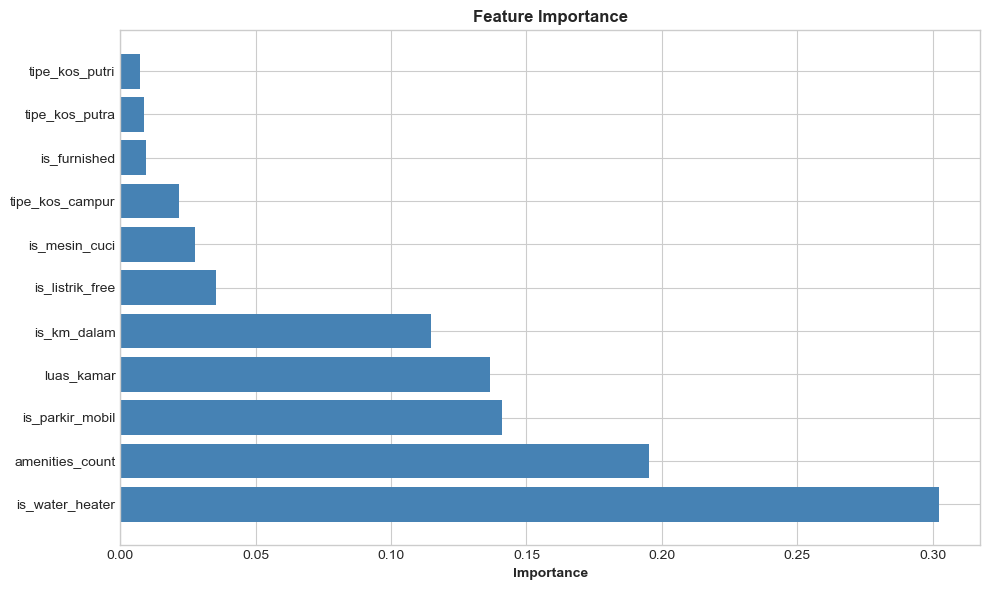

In [63]:
print("Feature Importance")

if hasattr(final_model.named_steps['regressor'], 'feature_importances_'):
    importances = final_model.named_steps['regressor'].feature_importances_
    
    # Get feature names from preprocessor
    preprocessor_obj = final_model.named_steps['preprocessor']
    feature_names_list = []
    
    for name, transformer, columns in preprocessor_obj.transformers_:
        if name == 'continuous':
            feature_names_list.extend(columns)
        elif name == 'binary':
            feature_names_list.extend(columns)
        elif name == 'categorical':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names_list.extend(transformer.get_feature_names_out(columns))
            else:
                feature_names_list.extend(columns)
    
    indices = np.argsort(importances)[::-1]
    
    print("\nTop Features:")
    for i in range(min(5, len(indices))):
        print(f"{i+1}. {feature_names_list[indices[i]]}: {importances[indices[i]]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], color='steelblue')
    plt.yticks(range(len(indices)), [feature_names_list[j] for j in indices])
    plt.xlabel('Importance', fontweight='bold')
    plt.title('Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.show()

Hasil feature importance menunjukkan bahwa fasilitas dan ukuran fisik kamar merupakan penentu utama harga kos di Jakarta Selatan.

Fitur paling dominan adalah is_water_heater, yang mengindikasikan bahwa keberadaan water heater menjadi sinyal kuat segmentasi kos menengah ke atas di wilayah ini. Hal ini sejalan dengan karakter pasar Jakarta Selatan yang sensitif terhadap kenyamanan tambahan.

Selanjutnya, luas_kamar memberikan kontribusi besar terhadap harga, menegaskan bahwa ukuran ruang tetap menjadi faktor fundamental dalam pembentukan nilai kos.

Fitur agregat amenities_count juga memiliki peran signifikan, yang menunjukkan bahwa efek kumulatif fasilitas lebih informatif dibandingkan melihat fasilitas secara terpisah pada model berbasis tree.

Fitur seperti kamar mandi dalam dan parkir mobil berperan sebagai faktor pendukung, sementara tipe kos (putra/putri/campur) memiliki pengaruh relatif kecil terhadap harga dibandingkan aspek kenyamanan dan fasilitas.

Secara keseluruhan, hasil ini memperkuat keputusan desain fitur yang memprioritaskan amenities dan karakteristik fisik kamar untuk pemodelan harga kos di Jakarta Selatan.

---

## NOTEBOOK SUMMARY & METHODOLOGY

Notebook ini mendokumentasikan proses end-to-end machine learning untuk memprediksi harga kos berdasarkan karakteristik properti dan fasilitas.

Proses dimulai dengan EDA untuk memahami distribusi harga, mendeteksi skewness dan outlier, serta mengevaluasi hubungan antar fitur. Outlier harga dan luas kamar ditangani menggunakan 99th percentile capping untuk mengurangi distorsi tanpa menghilangkan pola pasar yang valid.

Selanjutnya dilakukan feature engineering, dengan pemisahan desain fitur antara:
* Model linear, yang menggunakan fitur individual untuk menjaga interpretabilitas
* Model berbasis tree, yang menambahkan fitur agregat amenities_count untuk menangkap efek kumulatif fasilitas

Dataset dibagi menjadi train (±80%) dan test (±20%) dengan distribusi target yang seimbang. Beberapa model baseline diuji (Linear, Ridge, Lasso, Random Forest, Gradient Boosting) dan dievaluasi menggunakan MAE, R², RMSE, dan MAPE.

Untuk model tree-based, dilakukan gap-aware hyperparameter tuning guna mencegah overfitting dengan mengontrol selisih performa train–test. Model akhir dipilih berdasarkan performa test set, stabilitas generalisasi, serta analisis residual.

Hasil akhir menunjukkan model yang stabil, tidak overfitting, dan dapat dijelaskan secara domain, sehingga siap digunakan untuk tahap deployment atau analisis lanjutan.